Using device: cuda
HR images: 800, LR images: 800
Calculated Mean: [0.44780516624450684, 0.43704643845558167, 0.40469399094581604], Std: [0.27867591381073, 0.26514777541160583, 0.2879892885684967]
Train Dataset: 700 samples
Validation Dataset: 100 samples
Test Dataset: 100 samples
HR images: 800, LR images: 800
Calculated Mean: [0.44487297534942627, 0.43638646602630615, 0.40414389967918396], Std: [0.280892014503479, 0.26644667983055115, 0.28876736760139465]
Train Dataset: 700 samples
Validation Dataset: 100 samples
Test Dataset: 100 samples


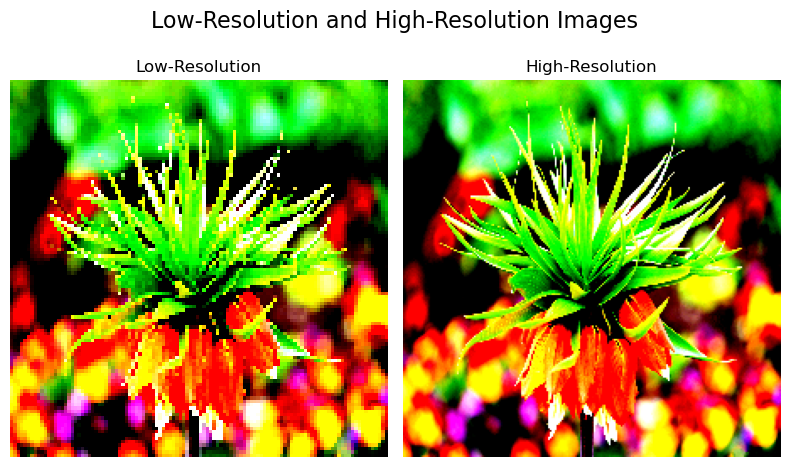

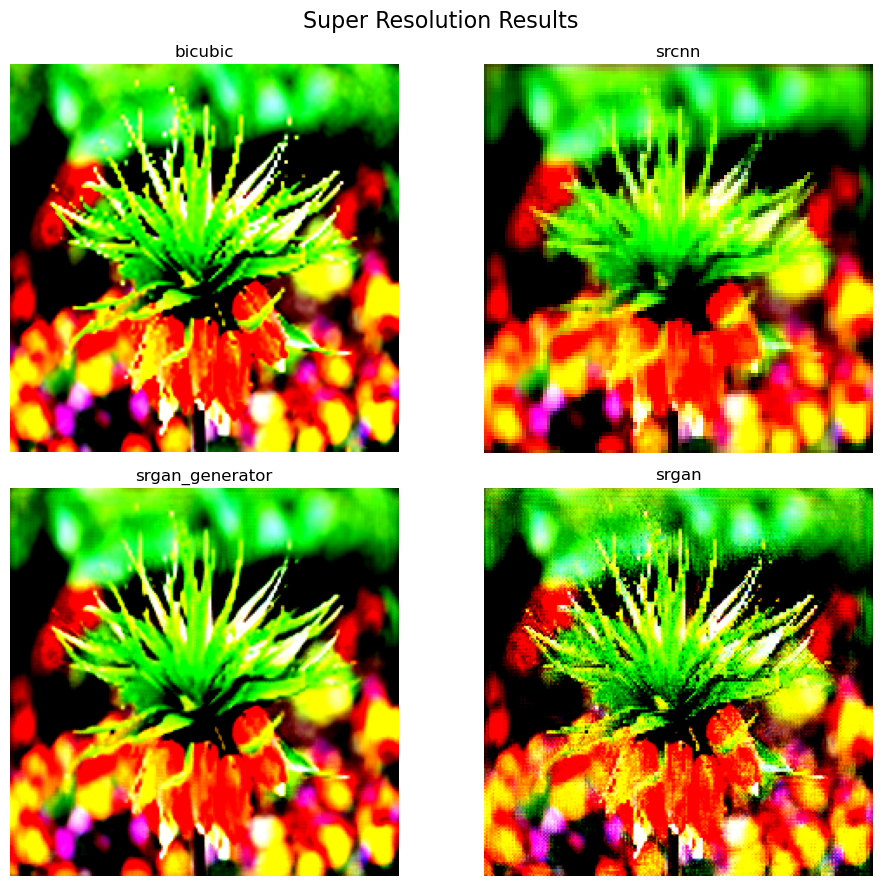

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from models.srcnn import SRCNN
from models.srgan import Generator, Discriminator
from load_dataset import get_dataloaders
from utils import bicubic_interpolation


def compare_images(models, model_paths, device, test_loader, srgan_test_loader, img_index):
    """
    Compare SR results from multiple models on a specific test image.

    Args:
        models (list): List of model names (e.g., ['bicubic', 'srcnn', 'srgan_generator', 'srgan']).
        model_paths (list): List of paths to model state dictionaries (for non-bicubic models).
        device (torch.device): Device to run the models on.
        test_loader (DataLoader): DataLoader for bicubic, srcnn, and srgan_generator models.
        srgan_test_loader (DataLoader): DataLoader for srgan model.
        img_index (int): Index of the image to visualize.
    """
    assert len(models) == 4, "Four models are required: ['bicubic', 'srcnn', 'srgan_generator', 'srgan']"
    assert len(models) - 1 == len(model_paths), "Provide paths for all models except bicubic."

    # Initialize models
    loaded_models = {}

    # Load SRCNN
    srcnn = SRCNN().to(device)
    srcnn.load_state_dict(torch.load(model_paths[0], map_location=device))
    srcnn.eval()
    loaded_models['srcnn'] = srcnn

    # Load SRGAN Generator
    srgan_generator = Generator().to(device)
    srgan_generator.load_state_dict(torch.load(model_paths[1], map_location=device))
    srgan_generator.eval()
    loaded_models['srgan_generator'] = srgan_generator

    # Load SRGAN (complete model with generator)
    srgan = Generator().to(device)
    srgan.load_state_dict(torch.load(model_paths[2], map_location=device))
    srgan.eval()
    loaded_models['srgan'] = srgan

    # Fetch the specified image
    lr_images, hr_images = next(iter(test_loader))
    if img_index >= len(lr_images):
        raise ValueError(f"Image index {img_index} is out of bounds for the dataset size {len(lr_images)}.")

    lr_image = lr_images[img_index].cpu().numpy().transpose(1, 2, 0)  # CHW -> HWC
    hr_image = hr_images[img_index].cpu().numpy().transpose(1, 2, 0)  # CHW -> HWC

    # Generate SR images
    sr_results = {}

    # Bicubic interpolation
    sr_results['bicubic'] = bicubic_interpolation(lr_image, scale_factor=2)

    # SRCNN
    with torch.no_grad():
        lr_tensor = lr_images[img_index:img_index + 1].to(device)
        sr_tensor = srcnn(lr_tensor)
        sr_results['srcnn'] = sr_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # SRGAN Generator
    with torch.no_grad():
        lr_tensor = lr_images[img_index:img_index + 1].to(device)
        sr_tensor = srgan_generator(lr_tensor)
        sr_results['srgan_generator'] = sr_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # SRGAN (with SRGAN-specific loader)
    lr_images_srgan, _ = next(iter(srgan_test_loader))
    if img_index >= len(lr_images_srgan):
        raise ValueError(f"Image index {img_index} is out of bounds for the SRGAN dataset size {len(lr_images_srgan)}.")

    lr_image_srgan = lr_images_srgan[img_index:img_index + 1].to(device)
    with torch.no_grad():
        sr_tensor = srgan(lr_image_srgan)
        sr_results['srgan'] = sr_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # Plot LR and HR
    fig1, axes1 = plt.subplots(1, 2, figsize=(8, 5))
    fig1.suptitle("Low-Resolution and High-Resolution Images", fontsize=16)
    axes1[0].imshow(np.clip(lr_image, 0, 1))
    axes1[0].set_title("Low-Resolution")
    axes1[0].axis("off")
    axes1[1].imshow(np.clip(hr_image, 0, 1))
    axes1[1].set_title("High-Resolution")
    axes1[1].axis("off")
    plt.tight_layout()
    plt.show()

    # Plot SR results
    fig2, axes2 = plt.subplots(2, 2, figsize=(10, 9))
    fig2.suptitle("Super Resolution Results", fontsize=16)
    for idx, (model_name, sr_image) in enumerate(sr_results.items()):
        row, col = divmod(idx, 2)
        axes2[row, col].imshow(np.clip(sr_image, 0, 1))
        axes2[row, col].set_title(f"{model_name}")
        axes2[row, col].axis("off")
    plt.tight_layout()
    plt.show()



# main part
models = ['bicubic', 'srcnn', 'srgan_generator', 'srgan']
ds_rate = 2
model_paths_ds_rate2 = ['./results/models/srcnn_x2_batch32_epoch100_lr0.0002_12-09_13-44.pth',
                        './results/models/srgan_generator_x2_batch32_epoch100_lr0.0002_12-10_17-28.pth',
                        './results/models/srgan_x2_batch16_epoch100_lr0.0002_12-09_22-22.pth']
model_paths_ds_rate3 = ['./results/models/srcnn_x3_batch32_epoch100_lr0.0002_12-09_18-08.pth',
                        './results/models/srgan_generator_x3_batch32_epoch100_lr0.0002_12-10_19-11.pth',
                        './results/models/srgan_x3_batch16_epoch100_lr0.0002_12-10_03-33.pth']
model_paths_ds_rate4 = ['./results/models/srcnn_x4_batch32_epoch100_lr0.0002_12-09_20-17.pth',
                        './results/models/srgan_generator_x4_batch32_epoch100_lr0.0002_12-11_02-47.pth',
                        './results/models/srgan_x4_batch16_epoch100_lr0.0002_12-10_13-06.pth']
if ds_rate == 2:
    model_paths = model_paths_ds_rate2
elif ds_rate == 3:
    model_paths = model_paths_ds_rate3
elif ds_rate == 4:
    model_paths = model_paths_ds_rate4
else:
    raise ValueError('ds_rate should be 2 or 3 or 4')

# device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# load datasets
train_hr_folder = f"./dataset/DIV2K_train_HR"
train_lr_folder = f"./dataset/DIV2K_train_LR_bicubic/X{ds_rate}"
valid_hr_folder = f"./dataset/DIV2K_valid_HR"
valid_lr_folder = f"./dataset/DIV2K_valid_LR_bicubic/X{ds_rate}"

_, val_loader, test_loader = get_dataloaders(
    train_hr_folder=train_hr_folder,
    train_lr_folder=train_lr_folder,
    val_hr_folder=valid_hr_folder,
    val_lr_folder=valid_lr_folder,
    batch_size=16,
    num_workers=1,
    use_imagenet_norm=False
)
_, srgan_val_loader, srgan_test_loader = get_dataloaders(
    train_hr_folder=train_hr_folder,
    train_lr_folder=train_lr_folder,
    val_hr_folder=valid_hr_folder,
    val_lr_folder=valid_lr_folder,
    batch_size=16,
    num_workers=1,
    use_imagenet_norm=False
)


compare_images(models, model_paths, device, val_loader, srgan_val_loader, img_index=2)